In [2]:
import torch
from torch import nn

In [3]:
lenet = nn.Sequential(nn.Conv2d(1,6, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2,stride=2),
                    nn.Conv2d(6,16,kernel_size=5), 
                    nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), 
                    nn.Sigmoid(),
                    nn.Linear(120,84), nn.Sigmoid(), nn.Linear(84,10)
                    )

In [4]:
X = torch.randn((1,1,28,28))

In [5]:
for layer in lenet:
    X = layer(X)
    
    print(f"Shape of {layer.__class__.__name__} : {X.shape}")

Shape of Conv2d : torch.Size([1, 6, 28, 28])
Shape of Sigmoid : torch.Size([1, 6, 28, 28])
Shape of AvgPool2d : torch.Size([1, 6, 14, 14])
Shape of Conv2d : torch.Size([1, 16, 10, 10])
Shape of Sigmoid : torch.Size([1, 16, 10, 10])
Shape of AvgPool2d : torch.Size([1, 16, 5, 5])
Shape of Flatten : torch.Size([1, 400])
Shape of Linear : torch.Size([1, 120])
Shape of Sigmoid : torch.Size([1, 120])
Shape of Linear : torch.Size([1, 84])
Shape of Sigmoid : torch.Size([1, 84])
Shape of Linear : torch.Size([1, 10])


In [6]:
batch_size = 256


import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [7]:
my_transforms = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root="../data", download=False, train=True, transform=my_transforms)
test_dataset = datasets.FashionMNIST(root="../data", download=False, train=False, transform=my_transforms)

In [8]:
X,y = train_dataset[0]
X.shape,y

(torch.Size([1, 28, 28]), 9)

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [10]:
for X, y in train_dataloader:
    print(X, y)
    break

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

Since the full dataset is in the main memory, we need to copy it to the
GPU memory before the model uses GPU to compute with the dataset

In [11]:
def accuracy(y_hat, y):
    return (y_hat.argmax(1)==y).sum()

In [12]:
def evaluate_accuracy_gpu(net, data_iter):
    if isinstance(net, nn.Module):
        net.eval()
        
        device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
    
    acc_arr = 0
    total_number = 0
    
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device).float()
            y = y.to(device).float()
            net = net.to(device)
            y_hat = net(X)
            acc_arr += accuracy(y_hat, y)
            total_number += y.numel()

    return acc_arr/total_number
        
        

In [13]:
#before training
evaluate_accuracy_gpu(lenet, test_dataloader)

tensor(0.1000, device='cuda:0')

In [14]:
import matplotlib.pyplot as plt

In [15]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    
    net.apply(init_weights)
    
    print(f'training on {device}')
    
    net = net.to(device)
    
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    
    train_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        current_l = 0
        current_numer = 0
        current_acc = 0
        net.train()
        for i, (X, y) in enumerate(train_iter):
            X = X.to(device).float()
            y = y.to(device).long()
            
            y_hat = net(X)
          
            l = loss_criterion(y_hat, y)
            optimizer.zero_grad()
        
            l.backward()
        
            optimizer.step()
            
            current_l += l
            current_numer += X.shape[0]
            current_acc += accuracy(y_hat, y)
            
        print(f'\nFor epoch {epoch} the loss {current_acc/ current_numer}')
        
        with torch.no_grad():
            
            print("\tStatistics:")
            print(f'\tcurrent train loss : {float(current_l/current_numer)}')
            print(f'\tcurrent train acc : {float(current_acc/current_numer)}')
            print(f'\tcurrent test acc : {float(evaluate_accuracy_gpu(net, test_iter))}')
    
            train_loss.append(float(current_l/current_numer))
            train_acc.append(float(current_acc/current_numer))
            test_acc.append(float(evaluate_accuracy_gpu(net, test_iter)))
    
    with torch.no_grad():
        print(len(train_loss), len(train_acc), len(test_acc))
        print(type(train_loss), type(train_acc), type(test_acc))
        plt.plot(range(num_epochs), train_loss)
        plt.plot(range(num_epochs), train_acc)
        plt.plot(range(num_epochs), test_acc)
        plt.grid(True)
        plt.show()
        

training on cuda

For epoch 0 the loss 0.0982000008225441
	Statistics:
	current train loss : 0.009084771387279034
	current train acc : 0.0982000008225441
	current test acc : 0.09999999403953552

For epoch 1 the loss 0.20385000109672546
	Statistics:
	current train loss : 0.008115887641906738
	current train acc : 0.20385000109672546
	current test acc : 0.4659999907016754

For epoch 2 the loss 0.6004666686058044
	Statistics:
	current train loss : 0.0038968021981418133
	current train acc : 0.6004666686058044
	current test acc : 0.6597999930381775

For epoch 3 the loss 0.6965166926383972
	Statistics:
	current train loss : 0.0030336384661495686
	current train acc : 0.6965166926383972
	current test acc : 0.6940999627113342

For epoch 4 the loss 0.7352499961853027
	Statistics:
	current train loss : 0.0026485847774893045
	current train acc : 0.7352499961853027
	current test acc : 0.6926000118255615

For epoch 5 the loss 0.7590833306312561
	Statistics:
	current train loss : 0.0024256063625216484

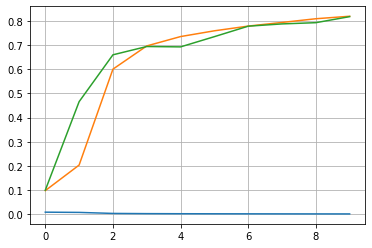

In [16]:
lr, num_epochs = 0.005, 10

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

train_ch6(lenet, train_iter=train_dataloader, test_iter=test_dataloader, num_epochs=num_epochs, lr=0.9, device=device)

## Exercises

1. Replace the average pooling with maximum pooling. What happens?

    * has the almost the same .8177 and .8148

1. Try to construct a more complex network based on LeNet to improve its accuracy.
    1. Adjust the convolution window size.
    1. Adjust the number of output channels.
    1. Adjust the activation function (e.g., ReLU).
    1. Adjust the number of convolution layers.
    1. Adjust the number of fully connected layers.
    1. Adjust the learning rates and other training details (e.g., initialization and number of epochs.)
    
    * my changed network.
    ```python
    lenet_improved = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(16, 32, kernel_size=4), nn.ReLU(),
                    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(32, 240), nn.ReLU(),
                    nn.Linear(240,120), nn.ReLU(),
                    nn.Linear(120, 84), nn.ReLU(), nn.Linear(84, 10))

    ```
    
1. Try out the improved network on the original MNIST dataset.

    * did try.
    
1. Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).

    * was this what was meant?
    
    ```python
    activation_from_first = nn.Sequential(net[0], net[1])
    activation_from_second = nn.Sequential(net[0],net[1], net[2], net[3])

    activation_from_first(X[0].unsqueeze(0)).shape, activation_from_second(X[2].unsqueeze(0)).shape
    ```

In [17]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))

training on cuda

For epoch 0 the loss 0.10100000351667404
	Statistics:
	current train loss : 0.009083912707865238
	current train acc : 0.10100000351667404
	current test acc : 0.09999999403953552

For epoch 1 the loss 0.23579999804496765
	Statistics:
	current train loss : 0.00778692401945591
	current train acc : 0.23579999804496765
	current test acc : 0.48589998483657837

For epoch 2 the loss 0.6017666459083557
	Statistics:
	current train loss : 0.003843797603622079
	current train acc : 0.6017666459083557
	current test acc : 0.6029999852180481

For epoch 3 the loss 0.6999333500862122
	Statistics:
	current train loss : 0.0030223061330616474
	current train acc : 0.6999333500862122
	current test acc : 0.6815999746322632

For epoch 4 the loss 0.7396000027656555
	Statistics:
	current train loss : 0.0026089297607541084
	current train acc : 0.7396000027656555
	current test acc : 0.6715999841690063

For epoch 5 the loss 0.7629500031471252
	Statistics:
	current train loss : 0.002394314389675855

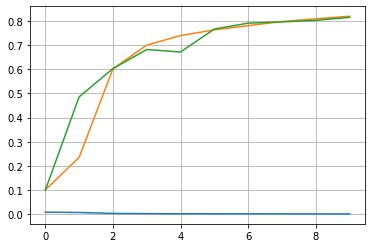

In [18]:
train_ch6(lenet, train_iter=train_dataloader, test_iter=test_dataloader, num_epochs=num_epochs, lr=0.9, device=device)

In [20]:
# 4

counter = []

for X,y in train_dataloader:
    counter.append((X,y))
    if len(counter) == 2:
        break
counter[0]

(tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0078,  ..., 0.0078, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.2824,  ..., 0.5333, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.2118,  ..., 0.2275, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.1020, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000

In [23]:
X, y = counter[0]

y[0], y[2]

(tensor(6), tensor(7))

In [28]:
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [31]:
activation_from_first = nn.Sequential(net[0], net[1])
activation_from_second = nn.Sequential(net[0],net[1], net[2], net[3])

activation_from_first(X[0].unsqueeze(0)).shape, activation_from_second(X[2].unsqueeze(0)).shape

(torch.Size([1, 6, 28, 28]), torch.Size([1, 16, 10, 10]))

In [32]:
# 3

# getting mnist

mnist_train_dataset = datasets.MNIST(root="../data",download=True, train=True, transform=my_transforms)
mnist_test_dataset = datasets.MNIST(root="../data", download=True, train=False, transform=my_transforms)

mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)

0it [00:00, ?it/s]

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]

Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


z:\installs\anconda\envs\myenv\lib\site-packages\torchvision\datasets\mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


In [58]:
#4

lenet_improved = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(16, 32, kernel_size=4), nn.ReLU(),
                    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                    nn.Linear(32, 240), nn.ReLU(),
                    nn.Linear(240,120), nn.ReLU(),
                    nn.Linear(120, 84), nn.ReLU(), nn.Linear(84, 10))


In [62]:
X = torch.randn((1,1,28,28))
X.shape

torch.Size([1, 1, 28, 28])

In [53]:
lenet_improved[0]

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

In [54]:
lenet_improved[0](X)

tensor([[[[-4.0815e-02, -4.1642e-01,  3.3162e-01,  ..., -2.5094e-01,
            2.5662e-01, -5.7867e-01],
          [ 1.5078e-01, -5.4104e-01,  2.8076e-02,  ..., -7.8395e-01,
            9.1427e-01, -4.2964e-01],
          [-3.1678e-01, -6.8506e-01, -7.4785e-02,  ...,  1.7410e-01,
           -4.1168e-01, -4.4575e-01],
          ...,
          [ 7.0028e-01, -8.2389e-01, -9.3894e-02,  ...,  7.4472e-02,
           -1.8594e+00, -5.4426e-01],
          [ 1.6452e-01,  3.0222e-01,  3.8585e-01,  ..., -3.8495e-01,
            1.6415e-01,  1.4936e+00],
          [ 3.9892e-01,  4.9043e-01,  8.3045e-03,  ...,  5.0615e-01,
           -1.3416e-01, -7.1709e-01]],

         [[ 3.6008e-01,  3.2745e-01, -5.9760e-02,  ..., -4.1414e-02,
            3.3652e-01,  2.8017e-01],
          [ 9.0645e-02,  3.0513e-01,  2.6756e-01,  ...,  6.2361e-01,
            3.2318e-01,  2.9720e-01],
          [ 5.5881e-01, -2.6925e-01, -3.5959e-01,  ..., -3.2166e-01,
           -6.0559e-01,  2.9857e-02],
          ...,
     

In [63]:
for layer in lenet_improved:
    
    X = layer(X)
    
    print(f"Shape of {layer.__class__.__name__} :{X.shape}")

Shape of Conv2d :torch.Size([1, 6, 28, 28])
Shape of ReLU :torch.Size([1, 6, 28, 28])
Shape of AvgPool2d :torch.Size([1, 6, 14, 14])
Shape of Conv2d :torch.Size([1, 16, 10, 10])
Shape of ReLU :torch.Size([1, 16, 10, 10])
Shape of AvgPool2d :torch.Size([1, 16, 5, 5])
Shape of Conv2d :torch.Size([1, 32, 2, 2])
Shape of ReLU :torch.Size([1, 32, 2, 2])
Shape of AvgPool2d :torch.Size([1, 32, 1, 1])
Shape of Flatten :torch.Size([1, 32])
Shape of Linear :torch.Size([1, 240])
Shape of ReLU :torch.Size([1, 240])
Shape of Linear :torch.Size([1, 120])
Shape of ReLU :torch.Size([1, 120])
Shape of Linear :torch.Size([1, 84])
Shape of ReLU :torch.Size([1, 84])
Shape of Linear :torch.Size([1, 10])


For LR value 0.3

training on cuda

For epoch 0 the loss 0.10813333094120026
	Statistics:
	current train loss : 0.00907556526362896
	current train acc : 0.10813333094120026
	current test acc : 0.09999999403953552

For epoch 1 the loss 0.4930500090122223
	Statistics:
	current train loss : 0.005058921407908201
	current train acc : 0.4930500090122223
	current test acc : 0.5996999740600586

For epoch 2 the loss 0.6727833151817322
	Statistics:
	current train loss : 0.0033044079318642616
	current train acc : 0.6727833151817322
	current test acc : 0.6656000018119812

For epoch 3 the loss 0.7261333465576172
	Statistics:
	current train loss : 0.002761856419965625
	current train acc : 0.7261333465576172
	current test acc : 0.7127000093460083

For epoch 4 the loss 0.7512166500091553
	Statistics:
	current train loss : 0.002486173063516617
	current train acc : 0.7512166500091553
	current test acc : 0.7511999607086182

For epoch 5 the loss 0.7777667045593262
	Statistics:
	current train loss : 0.0022

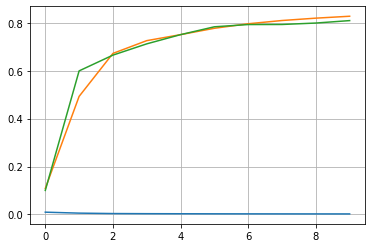

For LR value 0.8

training on cuda

For epoch 0 the loss 0.10333333164453506
	Statistics:
	current train loss : 0.009083203040063381
	current train acc : 0.10333333164453506
	current test acc : 0.09999999403953552

For epoch 1 the loss 0.3411666750907898
	Statistics:
	current train loss : 0.006741155870258808
	current train acc : 0.3411666750907898
	current test acc : 0.5175999999046326

For epoch 2 the loss 0.6334500312805176
	Statistics:
	current train loss : 0.003610671265050769
	current train acc : 0.6334500312805176
	current test acc : 0.6830999851226807

For epoch 3 the loss 0.7079333662986755
	Statistics:
	current train loss : 0.0029316877480596304
	current train acc : 0.7079333662986755
	current test acc : 0.725600004196167

For epoch 4 the loss 0.7436167001724243
	Statistics:
	current train loss : 0.0025913442950695753
	current train acc : 0.7436167001724243
	current test acc : 0.739799976348877

For epoch 5 the loss 0.7656166553497314
	Statistics:
	current train loss : 0.0023

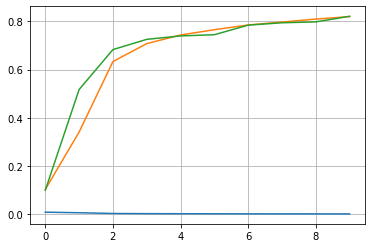

For LR value 0.03

training on cuda

For epoch 0 the loss 0.1112833321094513
	Statistics:
	current train loss : 0.00906441267579794
	current train acc : 0.1112833321094513
	current test acc : 0.09999999403953552

For epoch 1 the loss 0.48945000767707825
	Statistics:
	current train loss : 0.005044324789196253
	current train acc : 0.48945000767707825
	current test acc : 0.5710999965667725

For epoch 2 the loss 0.6740333437919617
	Statistics:
	current train loss : 0.003290103282779455
	current train acc : 0.6740333437919617
	current test acc : 0.6832999587059021

For epoch 3 the loss 0.7307166457176208
	Statistics:
	current train loss : 0.002711375942453742
	current train acc : 0.7307166457176208
	current test acc : 0.731499969959259

For epoch 4 the loss 0.7596666812896729
	Statistics:
	current train loss : 0.00242816936224699
	current train acc : 0.7596666812896729
	current test acc : 0.7789999842643738

For epoch 5 the loss 0.7825000286102295
	Statistics:
	current train loss : 0.002225

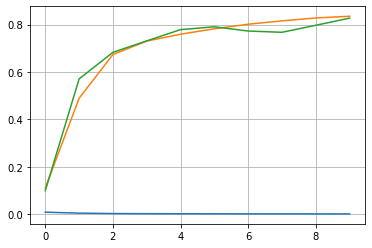

For LR value 0.08

training on cuda

For epoch 0 the loss 0.11006666719913483
	Statistics:
	current train loss : 0.00907718762755394
	current train acc : 0.11006666719913483
	current test acc : 0.1923999935388565

For epoch 1 the loss 0.5112500190734863
	Statistics:
	current train loss : 0.004848599433898926
	current train acc : 0.5112500190734863
	current test acc : 0.6060999631881714

For epoch 2 the loss 0.6705333590507507
	Statistics:
	current train loss : 0.003317495109513402
	current train acc : 0.6705333590507507
	current test acc : 0.7161999940872192

For epoch 3 the loss 0.7222000360488892
	Statistics:
	current train loss : 0.00278856442309916
	current train acc : 0.7222000360488892
	current test acc : 0.6823999881744385

For epoch 4 the loss 0.7551833391189575
	Statistics:
	current train loss : 0.00247865729033947
	current train acc : 0.7551833391189575
	current test acc : 0.7461999654769897

For epoch 5 the loss 0.775600016117096
	Statistics:
	current train loss : 0.00227764

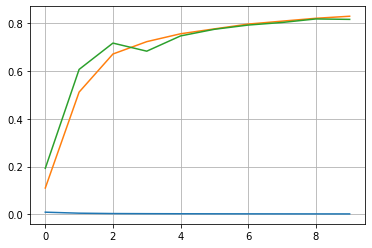

For LR value 0.003

training on cuda

For epoch 0 the loss 0.1619500070810318
	Statistics:
	current train loss : 0.008541407994925976
	current train acc : 0.1619500070810318
	current test acc : 0.40449997782707214

For epoch 1 the loss 0.5809833407402039
	Statistics:
	current train loss : 0.004091857932507992
	current train acc : 0.5809833407402039
	current test acc : 0.6459000110626221

For epoch 2 the loss 0.6840166449546814
	Statistics:
	current train loss : 0.0031737489625811577
	current train acc : 0.6840166449546814
	current test acc : 0.7261999845504761

For epoch 3 the loss 0.7303333282470703
	Statistics:
	current train loss : 0.0026931955944746733
	current train acc : 0.7303333282470703
	current test acc : 0.7113999724388123

For epoch 4 the loss 0.7574666738510132
	Statistics:
	current train loss : 0.002434731926769018
	current train acc : 0.7574666738510132
	current test acc : 0.7687000036239624

For epoch 5 the loss 0.7797333598136902
	Statistics:
	current train loss : 0.00

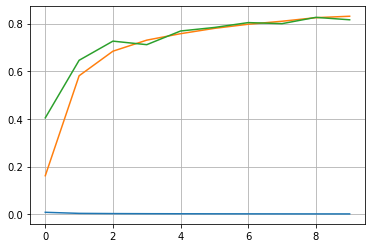

In [64]:
lr_array = [0.3, 0.8, 0.03 , 0.08, 0.003  ]

num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

for lr in lr_array:
    print(f"For LR value {lr}\n")
    train_ch6(lenet, train_iter=train_dataloader, test_iter=test_dataloader, num_epochs=num_epochs, lr=0.9, device=device)